# Working with Text Data

In Chapter 4, we talked about two kinds of features that can represent properties of the data: continuous features that describe a quantity, and categorical features that are items from a fixed list. There is a third kind of feature that can be found in many applications, which is **text**. For example, if we want to classify an email message as either a legitimate email or spam, the content of the email will certainly contain important information for this classification task. Or maybe we want to learn about the opinion of a politician on the topic of immigration. In customer service, we often want to find out if a message is a complaint or an inquiry.

Text data is usually represented as strings, made up of characters. The length of the text data will vary. This feature is clearly very different from the numeric features that we've discussed so far, and we will need to **process the data before we can apply our machine learning algorithms** to it.

## Types of Data Represented as Strings

Before we dive into the processing steps, we want to briefly discuss different kinds of text data. There are four kinds of string data you might see:

**Categorical data** comes from a fixed list (e.g., survey responses from a dropdown menu like "red", "green", "blue"). These should be one-hot encoded as discussed in Chapter 4.

**Free strings that can be semantically mapped to categories** -- like open text fields where users type a color name. These often contain typos, synonyms, and creative entries. Best encoded as categorical after manual cleanup.

**Structured string data** -- addresses, phone numbers, dates. Treatment is highly domain-dependent.

**Text data** -- freeform phrases and sentences: tweets, chat logs, reviews, articles. In the context of text analysis, the dataset is often called the **corpus**, and each data point is called a **document**. These terms come from the information retrieval (IR) and natural language processing (NLP) community.

## Example Application: Sentiment Analysis of Movie Reviews

As a running example in this chapter, we will use the **IMDb movie reviews** dataset collected by Stanford researcher Andrew Maas. This dataset contains the text of the reviews, together with a label that indicates whether a review is "positive" or "negative." The IMDb website itself contains ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a two-class classification dataset where reviews with a score of 6 or higher are labeled as positive, and the rest as negative.

## Setup

In [1]:
!pip install -q datasets nltk mglearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Patch mglearn.tools.heatmap for numpy/matplotlib compatibility
import mglearn.tools as _mt
def _patched_heatmap(values, xlabel, ylabel, xticklabels, yticklabels,
                     cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    values = np.array(values, dtype=np.float64)
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               values.ravel()):
        x, y = p.vertices[:-2, :].mean(0)
        c = 'k' if np.mean(color[:3]) > 0.5 else 'w'
        ax.text(x, y, fmt % float(value), color=c, ha="center", va="center")
    return img
_mt.heatmap = _patched_heatmap

## Loading the IMDb Dataset

We use the `datasets` library from Hugging Face to load the IMDb movie reviews dataset. This dataset contains 25,000 training reviews and 25,000 test reviews, each labeled as positive ($y = 1$) or negative ($y = 0$).

In [3]:
from datasets import load_dataset

# Load the IMDb dataset
imdb = load_dataset("imdb")

# Extract text and labels
text_train = imdb['train']['text']
y_train = np.array(imdb['train']['label'])

text_test = imdb['test']['text']
y_test = np.array(imdb['test']['label'])

print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1][:300]))

type of text_train: <class 'datasets.arrow_dataset.Column'>
length of text_train: 25000
text_train[1]:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity


We see that `text_train` contains 25,000 entries of type `datasets.arrow_dataset.Column` (Hugging Face's efficient columnar storage -- it behaves like a Python list for our purposes).

Looking at the sample review (index 1), we can already observe the richness and complexity of real-world text data: it contains proper nouns ("I Am Curious: Yellow"), informal language ("steaming pile"), subjective opinions, references to movie ratings (NC-17, R-rated), and nuanced argumentation. This is clearly a **negative** review. The reviews may also contain HTML formatting like `<br />` line breaks. While unlikely to have a large impact on our models, it is better to clean the data before we proceed:

In [4]:
# Clean HTML tags
text_train = [doc.replace("<br />", " ") for doc in text_train]
text_test = [doc.replace("<br />", " ") for doc in text_test]

The dataset was collected such that the positive class and the negative class are balanced:

In [5]:
print("Samples per class (training): {}".format(np.bincount(y_train)))
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Samples per class (training): [12500 12500]
Number of documents in test data: 25000
Samples per class (test): [12500 12500]


We have exactly 12,500 positive and 12,500 negative reviews in both the training and test sets -- a **perfectly balanced** binary classification problem with 25,000 training samples and 25,000 test samples. This is important for several reasons:

**Accuracy is a meaningful metric.** With 50/50 class balance, a naive classifier that always predicts one class would only achieve 50% accuracy. Any accuracy above 50% indicates genuine learning. In contrast, with an imbalanced dataset (say 90/10), a model achieving 90% accuracy might simply be predicting the majority class every time.

**No need for special techniques.** We don't need SMOTE, class weights, or stratified adjustments -- the natural class distribution is already ideal for training.

The task is: given a review text $d$, predict the label $y \in \{0, 1\}$ (negative or positive) based on the text content. This is a standard binary classification task, but the text data is not in a format that a machine learning model can handle. We need to convert the raw string representation into a **numeric representation** $\mathbf{x}_d \in \mathbb{R}^p$ that we can feed into our algorithms.

## Representing Text Data as a Bag of Words

One of the most simple but effective ways to represent text for machine learning is using the **bag-of-words** representation. When using this representation, we discard most of the structure of the input text (chapters, paragraphs, sentences, word order) and only count how often each word appears in each document.

Computing the bag-of-words representation consists of three steps:

**Step 1: Tokenization.** Split each document into the words that appear in it (called *tokens*), for example by splitting on whitespace and punctuation.

**Step 2: Vocabulary building.** Collect a vocabulary of all words that appear in any of the documents, and number them (say, in alphabetical order).

**Step 3: Encoding.** For each document, count how often each of the words in the vocabulary appear in this document.

Mathematically, if the vocabulary has $p$ unique words, then each document $d$ is represented as a vector $\mathbf{x}_d \in \mathbb{R}^p$ where:

$$x_{d,j} = \text{count of word } j \text{ in document } d$$

Note how the order of the words is completely irrelevant to the bag-of-words representation. The strings "good not bad" and "bad not good" produce **identical** feature vectors -- we'll address this limitation later with n-grams.

### Applying Bag-of-Words to a Toy Dataset

The bag-of-words representation is implemented in `CountVectorizer`. Let's first apply it to a toy dataset:

In [6]:
bards_words = ["The fool doth think he is wise,",
               "but the wise man knows himself to be a fool"]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

Fitting the `CountVectorizer` performs two operations under the hood: (1) it **tokenizes** both strings using the default regex pattern `\b\w\w+\b` (all sequences of at least two alphanumeric characters), converting everything to lowercase, and (2) it **builds a vocabulary** mapping each unique token to an integer index. We can access this vocabulary via the `vocabulary_` attribute:

In [8]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


The vocabulary consists of 13 unique words, each mapped to an integer index (e.g., `'be': 0`, `'but': 1`, ..., `'wise': 12`). These indices determine the **column positions** in the feature matrix -- column 0 counts occurrences of "be", column 3 counts "fool", and so on.

Notice several important preprocessing decisions made automatically: "The" was lowercased to "the" (case-insensitive), the comma and period were stripped (punctuation removal), and the single-letter word "a" was **excluded** because the regex `\b\w\w+\b` requires at least two characters. These are sensible defaults for most English text applications.

To create the bag-of-words representation, we call `transform`:

In [9]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 16 stored elements and shape (2, 13)>


The bag-of-words representation is stored in a **SciPy sparse matrix** that only stores the nonzero entries. The matrix has shape $2 \times 13$ (two documents, 13 vocabulary words), with only 16 nonzero entries out of $2 \times 13 = 26$ total. The **sparsity** is $1 - 16/26 \approx 38\%$ for this tiny example.

Why sparse storage? In real applications with vocabularies of 50,000+ words, a single review might use only a few hundred distinct words, so over 99% of entries are zero. For our IMDb dataset, the dense matrix would require:

$$25{,}000 \times 74{,}849 \times 8 \text{ bytes} \approx 14.8 \text{ GB}$$

The sparse representation stores only the $\sim$3.4 million nonzero entries, reducing memory by over 99%. To inspect the actual content, we convert to a dense array:

In [10]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


The word counts are all either 0 or 1 -- neither string contains any word twice. Let's trace through the feature vectors:

**Row 0** = `[0 0 1 1 1 0 1 0 0 1 1 0 1]` represents *"The fool doth think he is wise,"*. Reading the columns using our vocabulary mapping: "be"=0, "but"=0, "doth"=**1**, "fool"=**1**, "he"=**1**, "himself"=0, "is"=**1**, "knows"=0, "man"=0, "the"=**1**, "think"=**1**, "to"=0, "wise"=**1**. Total: 7 nonzero entries, matching the 7 unique words (after lowercasing "The" → "the").

**Row 1** = `[1 1 0 1 0 1 0 1 1 1 0 1 1]` represents *"but the wise man knows himself to be a fool"*. Total: 9 nonzero entries out of 10 words (the single-letter "a" was excluded by the tokenizer).

**Shared features:** "fool" (col 3), "the" (col 9), and "wise" (col 12) both have value 1 in both rows. In feature space, these shared features make the two documents appear somewhat similar -- despite having very different meanings. This is a fundamental limitation of bag-of-words.

### Bag-of-Words for Movie Reviews

Now let's apply the bag-of-words to our IMDb movie reviews:

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3431196 stored elements and shape (25000, 74849)>


The shape of `X_train` is $25{,}000 \times 74{,}849$, meaning the vocabulary contains **74,849 unique tokens** across all 25,000 training reviews. With 3,431,196 stored elements out of a potential $25{,}000 \times 74{,}849 \approx 1.87$ billion entries, the matrix is **99.8% sparse**.

On average, each review uses about $3{,}431{,}196 / 25{,}000 \approx 137$ distinct tokens from the vocabulary of 74,849. A typical review uses less than 0.2% of the available vocabulary -- this extreme sparsity is characteristic of text data and is why sparse matrix storage is essential.

Let's look at the vocabulary in more detail:

In [12]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
Features 20010 to 20030:
['dratted' 'draub' 'draught' 'draughts' 'draughtswoman' 'draw' 'drawback'
 'drawbacks' 'drawer' 'drawers' 'drawing' 'drawings' 'drawl' 'drawled'
 'drawling' 'drawn' 'draws' 'draza' 'dre' 'drea']
Every 2000th feature:
['00' 'aesir' 'aquarian' 'barking' 'blustering' 'bête' 'chicanery'
 'condensing' 'cunning' 'detox' 'draper' 'enshrined' 'favorit' 'freezer'
 'goldman' 'hasan' 'huitieme' 'intelligible' 'kantrowitz' 'lawful' 'maars'
 'megalunged' 'mostey' 'norrland' 'padilla' 'pincher' 'promisingly'
 'receptionist' 'rivals' 'schnaas' 'shunning' 'sparse' 'subset'
 'temptations' 'treatises' 'unproven' 'walkman' 'xylophonist']


There are 74,849 features. Looking at the vocabulary reveals several important observations:

**Numeric noise:** The first 20 features are all numbers: "00", "000", "0000000000001", "003830", etc. These numbers appear somewhere in the reviews and are extracted as tokens. Most have no semantic meaning -- apart from **"007"**, which in the context of movies is very likely a reference to James Bond.

**Morphological variants:** In features 20010-20030, we see "draught" / "draughts" / "draughtswoman", "draw" / "drawback" / "drawbacks" / "drawer" / "drawers" / "drawing" / "drawings" / "drawl" / "drawled" / "drawling" / "drawn" / "draws". All these morphological variants of the same root are treated as **separate features**. For sentiment analysis, "drawback" and "drawbacks" carry essentially the same meaning, and treating them as distinct features wastes model capacity and can increase overfitting. We'll address this later with stemming and lemmatization.

**Reasonable coverage:** The every-2000th sample shows a diverse mix across the alphabet ("aesir", "barking", "chicanery", "condensing", ...), confirming the vocabulary covers the full range of English words used in movie reviews.

Before we improve the feature extraction, let's build a baseline classifier. For high-dimensional, sparse data like this, linear models like `LogisticRegression` often work best:

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=5000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.84


We obtain a mean cross-validation score of **84%**, which is already a solid result. We've done nothing more than count words and feed 74,849 features into logistic regression.

The logistic regression model learns a weight $w_j$ for each word $j$ in the vocabulary, and predicts the probability of a positive review as:

$$P(y = 1 \mid \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(w_1 x_1 + w_2 x_2 + \cdots + w_p x_p + b)}}$$

**Intuition:** Each word acts like a "vote." Words with large positive $w_j$ (like "excellent") push the prediction toward positive, while words with large negative $w_j$ (like "terrible") push toward negative. The final prediction is the sigmoid-weighted sum of all the votes from all the words in the review.

We know that `LogisticRegression` has a regularization parameter $C$ which controls the trade-off between fitting the data and keeping the weights small. Let's tune it via cross-validation:

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.87
Best parameters:  {'C': 0.01}


Tuning $C$ improved the cross-validation score from 0.84 to **0.87** -- a meaningful 3 percentage point gain. The best parameter is $C = 0.01$, which is **much smaller than the default** $C = 1.0$.

This tells us something important about text data. With 74,849 features and only 25,000 training samples, we are in a **high-dimensional regime** ($p \gg n$). In such cases, strong regularization (small $C$) is essential to prevent overfitting. Recall that the logistic regression objective is:

$$\min_{\mathbf{w}} \quad C \sum_{i=1}^{n} \log\left(1 + e^{-y_i(\mathbf{w}^T \mathbf{x}_i + b)}\right) + \|\mathbf{w}\|_2^2$$

A small $C$ means the regularization term $\|\mathbf{w}\|_2^2$ dominates, forcing most word coefficients toward zero. This is appropriate: out of 74,849 words, the vast majority are irrelevant for sentiment, and the model should only assign substantial weights to the few hundred words that actually predict sentiment.

Now let's assess the generalization performance on the test set:

In [15]:
X_test = vect.transform(text_test)
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Test set score: 0.88


The test set accuracy is **88%** -- remarkably, this is *higher* than the cross-validation score of 87%. This can happen when the test set happens to be slightly "easier" than the cross-validation folds, and the small difference is not statistically meaningful. The key takeaway: the model generalizes well with no sign of overfitting.

This is a remarkably good result achieved with an extremely simple representation. We just counted words, fed 74,849 features into logistic regression with $C = 0.01$, and got 88% accuracy at binary sentiment classification. This demonstrates a key principle in NLP: **simple bag-of-words representations with regularized linear models are surprisingly powerful baselines** that more complex methods often struggle to beat by much.

### Improving Feature Extraction with `min_df`

The `CountVectorizer` tokenizes using the regex `\b\w\w+\b`, converting everything to lowercase. One way to reduce uninformative features (rare numbers, misspellings, obscure names) is to only keep tokens appearing in at least $k$ documents. A token appearing in only a single document out of 25,000 is unlikely to appear in the test set and therefore cannot help generalization:

In [16]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3354014 stored elements and shape (25000, 27271)>


By requiring at least 5 appearances (`min_df=5`), we reduced the vocabulary from **74,849 to 27,271** features -- only 36% of the original. Yet the stored elements dropped only from 3,431,196 to 3,354,014 -- a loss of merely $77{,}182$ nonzero entries (2.2% of total information). This means the **47,578 removed features collectively contributed only 2.2% of all word occurrences** in the training data. They were extremely rare tokens: typos, obscure proper nouns, and hapax legomena (words appearing only once).

Let's look at the remaining tokens:

In [17]:
feature_names = vect.get_feature_names_out()
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103' '104' '105' '107' '108' '10s'
 '10th' '11' '110' '112' '116' '117' '11th' '12' '120' '12th' '13' '135'
 '13th' '14' '140' '14th' '15' '150' '15th' '16' '160' '1600' '16mm' '16s'
 '16th']
Features 20010 to 20030:
['repentance' 'repercussions' 'repertoire' 'repetition' 'repetitions'
 'repetitious' 'repetitive' 'rephrase' 'replace' 'replaced' 'replacement'
 'replaces' 'replacing' 'replay' 'replayable' 'replayed' 'replaying'
 'replays' 'replete' 'replica']
Every 700th feature:
['00' 'affections' 'appropriately' 'barbra' 'blurbs' 'butchered' 'cheese'
 'commitment' 'courts' 'deconstructed' 'disgraceful' 'dvds' 'eschews'
 'fell' 'freezer' 'goriest' 'hauser' 'hungary' 'insinuate' 'juggle'
 'leering' 'maelstrom' 'messiah' 'music' 'occasional' 'parking'
 'pleasantville' 'pronunciation' 'recipient' 'reviews' 'sas' 'shea'
 'sneers' 'steiger' 'swastika' 'thrusting' 't

The vocabulary is much cleaner. Among the first 50 features, we still see numbers like "007", "00s", "10th" -- these survive because they appear in at least 5 reviews. The middle range (features 20010-20030) shows "repentance", "repercussions", "repertoire", "repetition" / "repetitions" / "repetitious" / "repetitive", "replace" / "replaced" / "replacement" / "replaces" / "replacing". The morphological variants are still treated as separate features -- stemming could help here.

The every-700th sample shows recognizable English words throughout. The most exotic artifacts have been filtered out. Let's see if this cleaner vocabulary improves performance:

In [18]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.87


The best validation accuracy is **still 0.87**, identical to before. We reduced the feature space from 74,849 to 27,271 features with **zero accuracy loss**. This confirms that the ~47,000 removed features were contributing nothing useful -- logistic regression with $C = 0.01$ had already effectively zeroed them out through regularization.

The practical gains are significant: **faster training** (the sparse matrix operations involve $\sim$63% fewer columns), **lower memory** usage, and **better interpretability** with fewer features to inspect. This illustrates an important principle: in text classification, the vast majority of the vocabulary is irrelevant noise. The model's performance is driven by a relatively small core vocabulary of common, sentiment-bearing words.

## Stopwords

Another way to reduce uninformative words is by discarding **stopwords** -- words that are too frequent to be informative (like "the", "and", "is"). There are two approaches: using a language-specific list, or discarding words that appear too frequently via `max_df`. scikit-learn has a built-in list:

In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['been', 'thereupon', 'something', 'rather', 'you', 'sixty', 'again', 'your', 'into', 'beyond', 'or', 'which', 'twelve', 'my', 'too', 'most', 'do', 'perhaps', 'from', 'might', 'its', 'are', 'whither', 'nobody', 'although', 'latter', 'there', 'five', 'anyhow', 'ie', 'this', 'until']


The built-in list contains 318 common English words -- articles ("the", "a"), prepositions ("into", "from"), pronouns ("you", "my"), auxiliary verbs ("been", "had"), and similar function words. These words appear in nearly every document and therefore carry little **document-level discriminative power** in information retrieval.

However, there's a critical nuance for **sentiment analysis**: some "stopwords" like "not", "no", "but", "too" carry important sentiment information. The phrase "not good" has the opposite meaning of "good", and removing "not" would destroy this signal entirely. Let's see what happens:

In [20]:
# Specifying stop_words="english" uses the built-in list
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2149958 stored elements and shape (25000, 26966)>


There are now 26,966 features compared to 27,271 without stopword removal -- a reduction of only **305 words** (not all 318 stopwords appeared in the `min_df=5`-filtered vocabulary). But notice that the number of stored elements dropped drastically from 3,354,014 to **2,149,958** -- a loss of over 1.2 million nonzero entries ($\sim$36%). This reveals that stopwords, despite being only 305 features, accounted for over a third of all word occurrences in the training data. They are extremely frequent but individually uninformative.

The question is whether removing them helps or hurts classification:

In [21]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.86


The grid search performance **decreased** from 0.87 to **0.86** after removing stopwords. This confirms our concern: for sentiment analysis, some "stopwords" carry critical information. Words like "not", "no", "but" are crucial for sentiment -- removing "not" from "not good" leaves just "good", which **flips the sentiment entirely**.

Fixed stopword lists were designed for information retrieval (finding documents about a topic), not for sentiment classification. For larger datasets like IMDb (25,000 reviews), logistic regression with proper regularization can learn to ignore truly uninformative words by assigning them near-zero weights, while keeping sentiment-critical function words active.

## Rescaling the Data with TF-IDF

Instead of dropping features, another approach is to **rescale features** by how informative we expect them to be. The most common method is **term frequency-inverse document frequency (TF-IDF)**. The intuition is: give high weight to words that appear often in a particular document but not in many documents across the corpus.

The TF-IDF score for word $w$ in document $d$ as implemented in scikit-learn is:

$$\text{tfidf}(w, d) = \underbrace{\text{tf}(w, d)}_{\substack{\text{how often } w \\ \text{appears in } d}} \cdot \underbrace{\left(\log\frac{N + 1}{N_w + 1} + 1\right)}_{\substack{\text{inverse document} \\ \text{frequency (IDF)}}}$$

where $N$ is the total number of training documents, $N_w$ is the number of documents containing word $w$, and $\text{tf}(w, d)$ is the count of word $w$ in document $d$.

**Intuition for the IDF factor:** If a word appears in every document ($N_w = N$), the IDF approaches $\log(1) + 1 = 1$ -- no boost. If a word appears in only one document ($N_w = 1$), the IDF becomes $\log(N) + 1$ -- a large boost. The logarithm prevents extremely rare words from receiving disproportionately high weights.

After computing TF-IDF, scikit-learn optionally applies $\ell_2$ normalization:

$$\tilde{\mathbf{x}}_d = \frac{\mathbf{x}_d}{\|\mathbf{x}_d\|_2}$$

This ensures that a 500-word review and a 50-word review get feature vectors of the same magnitude. Because TF-IDF uses statistical properties of the training data (document frequencies), we use a `Pipeline` (as in Chapter 6) to ensure valid cross-validation:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.86


The TF-IDF pipeline achieves **0.86** cross-validation accuracy with `norm=None` (no L2 normalization), comparable to the raw word count approach. The fact that TF-IDF doesn't dramatically outperform raw counts reflects that logistic regression with $\ell_2$ regularization already handles feature scaling: it can learn to downweight common words through smaller coefficients.

Let's inspect which words TF-IDF found most important. Keep in mind that TF-IDF is a **purely unsupervised technique** -- "important" here means "distinctive for a particular document," not necessarily "predictive of sentiment":

In [23]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))
print("\nFeatures with highest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'avoided' 'stinker' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']

Features with highest tfidf:
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'macarthur' 'taker'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


Features with **low TF-IDF** include words like "poignant", "disagree", "instantly", "inane" -- these either appear across many documents (reducing their IDF) or appear sparingly in a few documents (low TF). They don't strongly distinguish any particular document from the rest of the corpus.

Features with **high TF-IDF** are strikingly different: "homer", "dillinger", "hackenstein", "titanic", "timon", "zizek" -- almost all **proper nouns** identifying specific movies, characters, or directors. Words like "titanic" appear very frequently in reviews of that specific film but rarely elsewhere. Mathematically, if "titanic" appears 50 times in a single review ($\text{tf} = 50$) but in only a handful of documents ($N_w$ is small), the IDF factor $\log\frac{25{,}001}{N_w + 1}$ is large, producing a very high TF-IDF score.

These franchise-specific words are unlikely to help with general sentiment classification -- unless some franchises are universally reviewed positively or negatively. Let's also look at the words with the lowest IDF (most frequent across the corpus):

In [24]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
    feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


As expected, the words with the lowest IDF (most frequent across the corpus) are mostly English stopwords: "the", "and", "of", "to", "this", "is". But several **domain-specific** words also appear: "movie", "film", "story", "time", "acting" -- natural in a corpus of movie reviews.

Critically, notice that **"good"**, **"great"**, and **"bad"** are among the 100 most frequent words. TF-IDF considers them "least relevant" because they appear in so many documents (high $N_w$, low IDF). Yet for sentiment classification, these are among the **most predictive** words! This reveals the fundamental tension between **unsupervised** feature weighting (TF-IDF maximizes document distinctiveness) and **supervised** importance (which words actually predict the label $y$). TF-IDF was designed for information retrieval ("find documents about topic X"), not for classification.

### Investigating Model Coefficients

Let's look at what the logistic regression actually learned from the TF-IDF features. We examine the 25 largest and 25 smallest coefficients:

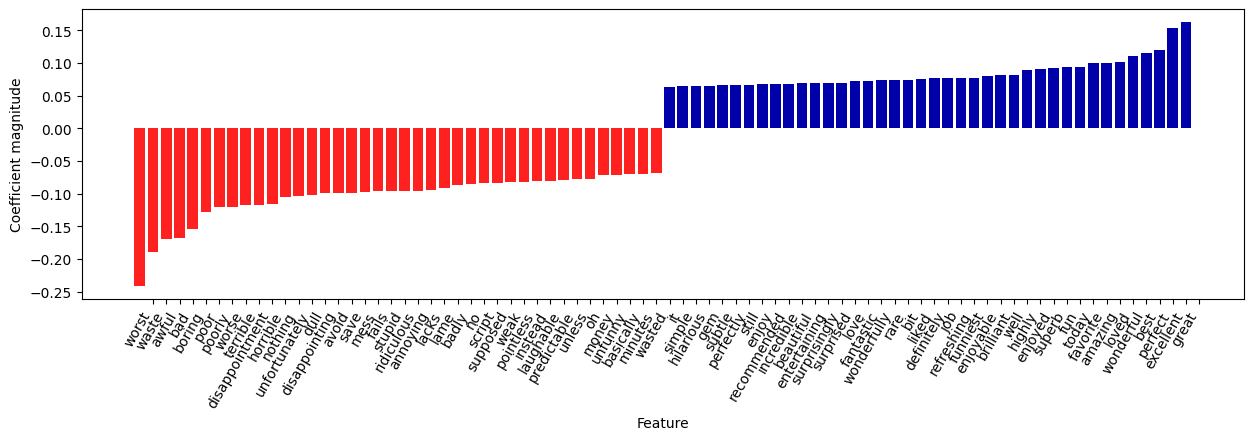

In [25]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

This bar chart is a direct window into the model's decision-making. Each bar represents a word's learned coefficient $w_j$ in the logistic regression:

$$\hat{y} = \text{sign}\left(\sum_{j=1}^{p} w_j \cdot \text{tfidf}(j, d) + b\right)$$

**Negative coefficients** (left side) indicate words associated with negative reviews. We see intuitively correct choices: "worst", "waste", "disappointment", "laughable", "awful", "poorly", "horrible" -- all words that humans would associate with negative sentiment.

**Positive coefficients** (right side) indicate words associated with positive reviews: "excellent", "wonderful", "enjoyable", "refreshing", "superb", "perfectly" -- again, intuitively correct.

Some words are less obvious: "bit" might appear in phrases like "a bit boring" (negative context), while "today" might occur in "still holds up today" (positive context). The unigram model cannot capture these phrase-level meanings -- it only sees individual words in isolation.

This direct interpretability -- being able to inspect exactly which words drive each prediction -- is one of the greatest strengths of linear models for NLP. In a production setting, this transparency is invaluable for debugging, stakeholder communication, and building trust in the model.

## Bag-of-Words with More Than One Word (n-Grams)

One of the main disadvantages of bag-of-words is that **word order is completely discarded.** The strings "it's bad, not good at all" and "it's good, not bad at all" produce identical feature vectors despite having inverted meanings. We can capture context by considering not just single tokens (**unigrams**), but also pairs (**bigrams**), triplets (**trigrams**), and more generally sequences of $n$ tokens (**n-grams**):

In [26]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


These are our two toy Shakespeare-inspired sentences. With `ngram_range=(1, 1)` (the default), `CountVectorizer` creates one feature per single token -- identical to what we saw before:

In [27]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out().tolist()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


With unigrams, we get the same 13 words. Each captures only a single word's presence: the model knows "fool", "wise", "the", and "man" all appeared, but it **cannot** distinguish "the fool" from "the wise man." To capture word pairs, we set `ngram_range` to $(2, 2)$:

In [28]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out().tolist()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


With bigrams only, the vocabulary grows to 14 two-word features. Notice something powerful: there is **no common bigram** between the two phrases. "the fool" only appears in the first string, "the wise" only in the second. Compare this to unigrams where "the", "fool", and "wise" were all shared -- bigrams are far more discriminative.

The bigrams preserve local word order: "the fool" and "fool the" would be separate features. The dense representation confirms the complete separation:

In [29]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


The two rows share **zero common features** -- the cosine similarity is exactly zero. In unigram space, the documents shared 3 features; in bigram space, they are completely orthogonal. This illustrates how n-grams provide much sharper discrimination, at the cost of a larger vocabulary.

Here is what using unigrams, bigrams, and trigrams together looks like:

In [30]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out().tolist()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


The vocabulary exploded from 13 (unigrams) to 39 (unigrams + bigrams + trigrams) for just two short sentences. In general, the number of possible n-grams scales combinatorially:

$$|\text{possible bigrams}| \leq |\text{unigrams}|^2, \quad |\text{possible trigrams}| \leq |\text{unigrams}|^3$$

In practice, the actual count is much smaller due to the structure of English (most random word combinations never occur), but it is still large. On the IMDb corpus, switching from unigrams ($\sim$27,000 features) to unigrams+bigrams+trigrams can produce **hundreds of thousands** of features.

For most applications, the minimum $n$ should be 1, as single words capture a lot of meaning. Adding bigrams helps by capturing phrases like "not good" or "well worth." Adding trigrams can help further but risks overfitting.

Let's try TF-IDF with n-grams on the IMDb data:

In [31]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.88
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}


Adding bigrams and trigrams improved performance from 0.86 (unigrams) to **0.88** -- a meaningful 2 percentage point gain. The best parameters are $C = 10$ with `ngram_range=(1, 3)`.

Notice the **dramatic shift in optimal regularization**: with unigrams only, the best $C$ was 0.01; with trigrams, it jumped to 10 -- a 1,000× increase. This makes sense: the n-gram feature space is much larger (potentially hundreds of thousands of features), and many n-gram features carry concentrated, unambiguous signal (e.g., "not worth" is almost always negative). The model needs **more capacity** (less regularization, higher $C$) to assign substantial weights to these informative features without shrinking them toward zero.

We can visualize the cross-validation accuracy as a heat map:

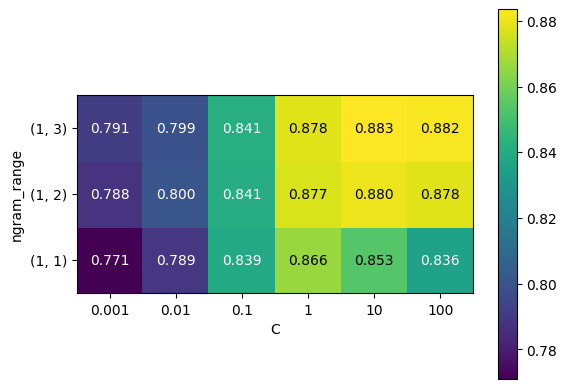

In [32]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

From the heat map we see a clear pattern. For **unigrams** (first row), the model peaks at small $C$ and degrades at large $C$ -- with 27,000+ ambiguous single-word features, strong regularization is needed. For **bigrams** (second row), performance improves across the board. For **trigrams** (third row), there is a further small improvement, especially at higher $C$.

The trend confirms: **more expressive features (n-grams) require less regularization** (higher $C$). Phrases like "not worth" carry clearer sentiment signal than individual words, so the model can afford to assign them larger weights without overfitting.

Let's visualize the most important features for the best model (all n-grams):

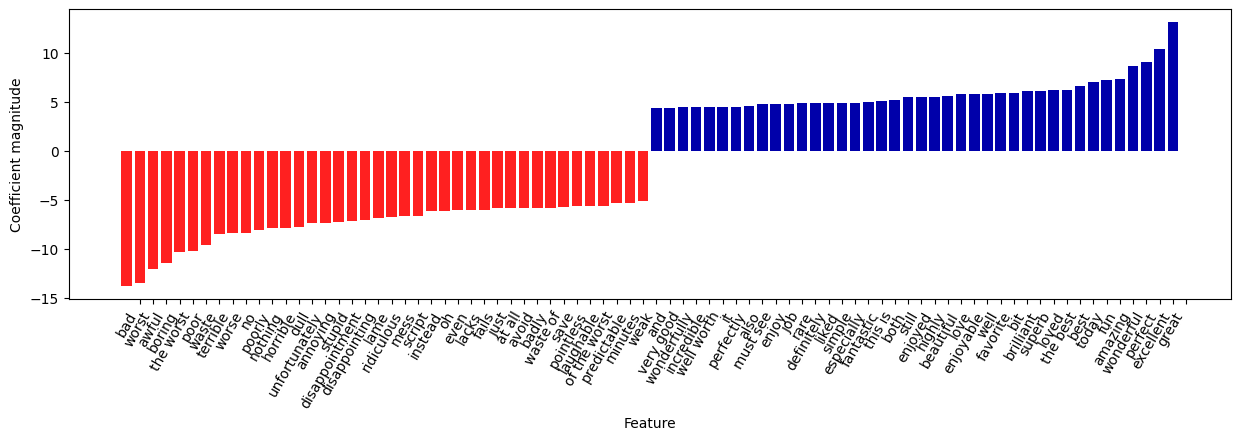

In [33]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

The n-gram features reveal context that unigrams could not capture. Particularly striking are features containing the word "worth": **"not worth"** has a strong negative coefficient, while **"definitely worth"** and **"well worth"** are strongly positive. The bare word "worth" is ambiguous -- its sentiment depends entirely on context. N-grams resolve this ambiguity.

Similarly, we see "waste of" (negative), "the worst" (negative), "one of" (often part of "one of the best" -- positive). These multi-word features capture semantic units that individual words cannot.

Let's visualize only the trigram features:

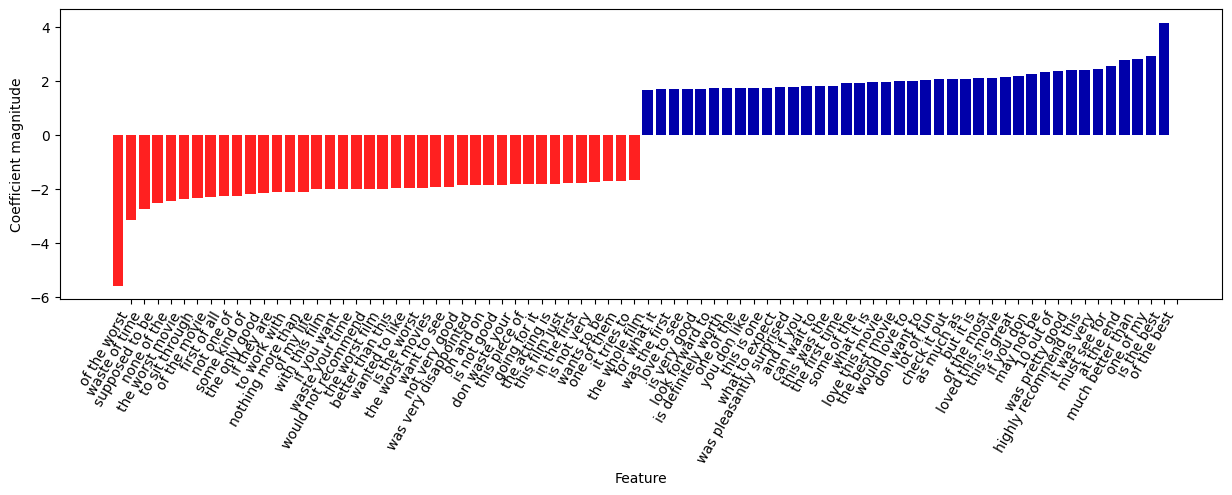

In [34]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
    feature_names[mask], n_top_features=40)

Many useful trigrams consist of common words that would not be informative individually: "none of the" (negative), "one of the" (positive, as in "one of the best"), "waste of time" (negative), "the only good" (positive). These phrases carry clear sentiment that their constituent unigrams do not.

However, the **coefficient magnitudes** of trigrams are typically smaller than those of unigrams and bigrams. The model primarily relies on unigrams for the bulk of its predictions, with bigrams providing the most additional value and trigrams offering marginal refinements. This is why the accuracy gain from adding trigrams (row 2 → row 3 in the heatmap) was much smaller than the gain from adding bigrams (row 1 → row 2).

## Advanced Tokenization, Stemming, and Lemmatization

The feature extraction in `CountVectorizer` and `TfidfVectorizer` is relatively simple, and much more elaborate methods are possible. One important improvement is in the **tokenization** step.

We saw earlier that the vocabulary contains "drawback" / "drawbacks", "replace" / "replaced" / "replacement" / "replaces" / "replacing". For bag-of-words, distinguishing these morphological variants only increases overfitting without adding semantic value.

This problem can be overcome by representing each word using its **word stem**:

**Stemming** uses rule-based heuristics to drop common suffixes. It's fast but sometimes produces non-words (e.g., "worse" → "wors").

**Lemmatization** uses a dictionary of known word forms and considers the grammatical role. It produces valid words (e.g., "worse" → "bad") but is much slower.

Let's compare the Porter stemmer from NLTK:

In [35]:
import nltk

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare stemming behavior
def show_stemming(doc):
    words = doc.split()
    print("Original: ", words)
    print("Stemmed:  ", [stemmer.stem(w.lower()) for w in words])

show_stemming("Our meeting today was worse than yesterday")
print()
show_stemming("I am scared of meeting the clients tomorrow")

Original:  ['Our', 'meeting', 'today', 'was', 'worse', 'than', 'yesterday']
Stemmed:   ['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday']

Original:  ['I', 'am', 'scared', 'of', 'meeting', 'the', 'clients', 'tomorrow']
Stemmed:   ['i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow']


The stemming output reveals both the power and limitations of the approach:

**Useful reductions:** "meeting" → "meet" (both occurrences), "scared" → "scare", "clients" → "client". These merge morphological variants into a single feature, reducing vocabulary size and potentially improving generalization.

**Imperfect truncations:** "was" → "wa", "worse" → "wors" -- these are not valid English words. The Porter stemmer applies fixed suffix-stripping rules that sometimes over-truncate. However, this doesn't matter for ML: the model doesn't care whether the feature name is "wors" or "worse" -- only that it **consistently** maps all forms of "worse", "worst", "worsening" to the same stem.

**Context blindness:** Both "Our meeting today" (noun) and "meeting the clients" (verb) produce "meet". The stemmer cannot distinguish parts of speech. A **lemmatizer** (like spaCy) would recognize "meeting" as a noun in the first case and leave it unchanged, while reducing the verb form to "meet".

In general, lemmatization produces better results but is computationally more expensive. Both techniques act as a form of **regularization** -- they reduce the effective vocabulary $p$, which helps most when the dataset is small. On large datasets like our 25,000-review IMDb corpus, the improvement from stemming or lemmatization is typically modest ($\sim$1%) because the model already has enough data to learn that "replaced" and "replacing" should receive similar weights.

## Topic Modeling and Document Clustering

One powerful unsupervised technique for text data is **topic modeling** -- assigning each document to one or multiple topics without labels. The most widely used method is **Latent Dirichlet Allocation (LDA)**.

### Latent Dirichlet Allocation

LDA models each document as a **mixture of topics**, and each topic as a **distribution over words**. Formally:

$$p(\text{word}_j \mid \text{document}_d) = \sum_{k=1}^{K} \underbrace{\theta_{d,k}}_{\substack{\text{topic weight} \\ \text{in doc } d}} \cdot \underbrace{\beta_{k,j}}_{\substack{\text{word probability} \\ \text{in topic } k}}$$

where $\theta_{d,k} \geq 0$ is how much document $d$ "belongs to" topic $k$ (with $\sum_k \theta_{d,k} = 1$), and $\beta_{k,j} \geq 0$ is how likely word $j$ is under topic $k$ (with $\sum_j \beta_{k,j} = 1$).

**Intuition:** Think of each review as being "about" a mix of topics -- maybe 40% horror genre, 30% acting quality, 30% negative sentiment. LDA discovers these latent topics automatically from the co-occurrence patterns of words.

For unsupervised text models, it is good to remove very common words. We remove words appearing in at least 15% of documents and limit the vocabulary to 10,000:

In [36]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

We will learn a topic model with 10 topics:

In [37]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# We build the model and transform the data in one step
document_topics = lda.fit_transform(X)

`LatentDirichletAllocation` has a `components_` attribute that stores how important each word is for each topic. The size is $(K, p)$ where $K$ is the number of topics and $p$ is the vocabulary size:

In [38]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


The `components_` matrix has shape $(10, 10{,}000)$: **10 rows** (one per topic) and **10,000 columns** (one per vocabulary word). Entry $\beta_{k,j}$ represents how important word $j$ is in topic $k$. Larger values mean the word is more characteristic of that topic. Each row can be thought of as a "word recipe" for generating documents about that topic.

To interpret the topics, we look at the highest-weight words in each:

In [39]:
# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names_out())

In [40]:
# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
family        music         comedy        world         thing         
father        musical       funny         war           worst         
young         role          cast          us            didn          
girl          cast          role          american      funny         
mother        john          performance   our           nothing       
woman         performance   actor         own           actually      
wife          songs         actors        history       10            
old           dance         plays         documentary   want          
son           star          played        real          got           
home          song          work          human         horror        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
dire

Judging from the most important words in each topic, we can attempt to interpret them as a data scientist would:

**Topic 0** (family, father, young, girl, mother, woman, wife): **Family dramas** -- movies centered on domestic relationships and family dynamics.

**Topic 1** (music, musical, role, cast, john, performance, songs): **Musicals and performances** -- films evaluated primarily on musical content and acting.

**Topic 2** (comedy, funny, cast, role, performance, actor): **Comedies** -- movies assessed on humor and acting quality.

**Topic 3** (world, war, us, american, our, own): **War/political films** -- movies dealing with conflict, patriotism, and national identity.

**Topic 4** (thing, worst, didn, funny, nothing, actually): **Negative reviews** -- this topic captures the *language of dissatisfaction* rather than a genre. Words like "worst", "didn", "nothing" are sentiment markers, not content descriptors.

With only 10 topics, each must be very broad. Some clearly capture **genres** (family, comedy, war, music), while others capture **sentiment** (negative language). This dual structure -- genre + sentiment -- is characteristic of movie review corpora.

Now let's learn a model with 100 topics for finer-grained analysis:

In [41]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

With 100 topics, we expect narrower, more interpretable themes. Let's examine a curated selection of interesting topics:

In [42]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names_out())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
green         ring          church        footage       wife          gay           lady          
jim           team          faith         werewolf      husband       subject       romantic      
bruce         ball          victor        beast         family        between       grace         
world         angle         priest        stock         woman         social        ship          
heston        big           ford          wolf          daughter      art           titanic       
carrey        cruel         religion      mummy         home          sexual        shop          
edward        got           catholic      melting       married       rather        rose          
robinson      away          irish         shirt         mother        real          grant         
god       

With 100 topics, the specialization is dramatically better. Each topic now represents a narrow, interpretable theme:

**Topic 7** (green, jim, bruce, world, heston): **Action/adventure** -- possibly Jim Carrey or Bruce Willis movies, Charlton Heston epics.

**Topic 16** (ring, team, ball, angle, player, match): **Sports movies** -- films about athletics, teams, and competition.

**Topic 24** (church, faith, victor, priest, religion): **Religious/spiritual themes** in films.

**Topic 25** (footage, werewolf, beast, stock, creature): **Horror/monster movies** -- creature features, found footage, supernatural horror.

**Topic 28** (wife, husband, family, woman, affair): **Domestic/relationship dramas** -- stories about marriages, affairs, and family conflict.

**Topic 36** (gay, subject, between, social, human): Movies dealing with **social themes, LGBTQ+ topics**, and human relationships.

**Topic 37** (lady, romantic, grace, ship): **Romance** movies -- love stories and period pieces.

**Topic 45** (song, songs, sing, musical, band, rock, dance): **Music-centered movies** -- musicals, musician biopics, concert films.

**Topic 54** (worst, awful, terrible, horrible, waste, boring): Pure **negative sentiment** -- the universal language of bad reviews, genre-independent.

**Topic 63** (funny, comedy, hilarious, laugh, jokes, humor): **Positive comedy reviews** -- the language of laughing and enjoying humor.

To verify our interpretations, we should check which actual reviews are most associated with each topic. Let's look at Topic 45 (music):

In [43]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics100[:, 45])[::-1]
# print the five documents where the topic is most important
for i in music[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

The title is onomatopoeic, the sound of a streetcar clacking on the rails. It is metaphoric for all that the people who live in the dump cannot have.

Alexandr "Sascha" Luzhin (John Turturro) is a former leading chess player attempting a comeback at an Italy-hosted tournament. His brilliance is unquestioned but his obsession with chess has stunted his growth in all other aspects of his life.

I was overtaken by the emotion. Unforgettable rendering of a wartime story which is unknown to most people.

Marlene Gorris has established herself as one of the world's great directors. This sensitive, visually beautiful film is based on a story by Vladimir Nabokov and captures well that writer's dark irony.

The movie is wonderful. It shows the man's work for the wilderness and a natural understanding of the harmony of nature, without being an "extreme" naturalist.



The reviews most strongly associated with Topic 45 indeed involve music or artistic content: a streetcar metaphor (artistic film), a chess biopic, a wartime drama with emotional music, and a Marlene Gorris directorial piece. The diversity shows that "music" in topic modeling captures not just movies *about* musicians, but also films with strong emotional or artistic qualities -- movies where the review language naturally includes words about songs, performances, and artistry.

This is why **verifying topics against actual documents** is essential: the top-weight words give us a hypothesis, and the top-scoring documents either confirm or refine that hypothesis.

Let's look at the overall importance of each topic by summing topic weights across all reviews:

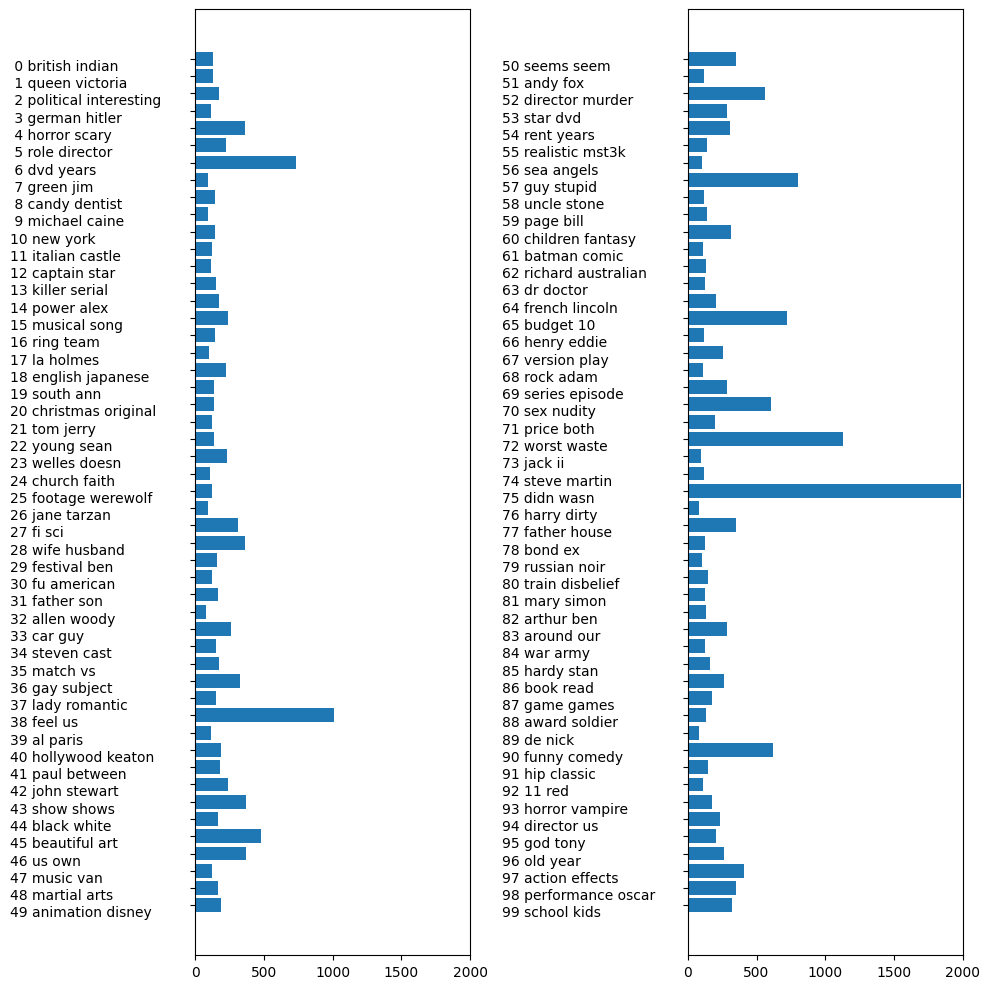

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

The horizontal bar chart reveals the "budget" allocated to each topic across the entire corpus of 25,000 reviews. Several patterns emerge:

**Dominant topics** (tallest bars) tend to be either **generic sentiment** topics (dominated by words like "worst", "great", "bad", "best") or **broad genre** topics (drama, comedy). These receive high total weight because sentiment language and broad genre descriptions appear in almost every review.

**Narrow specialist topics** (shortest bars) correspond to specific subjects like rare genres, particular actors, or niche themes. They receive low total weight because they apply to only a handful of reviews, but within those reviews they are dominant.

**The dual structure is clear:** LDA discovered two fundamental axes in the movie review corpus -- (1) **what the movie is about** (genre-specific topics: horror, comedy, drama, music, war, sports) and (2) **how the reviewer feels about it** (sentiment-specific topics: positive language, negative language). Most reviews are a mixture of both -- some genre-specific content description and some opinion-expressing language.

Topic models like LDA are powerful tools for understanding large text corpora, both with and without labels. The topic vectors $\boldsymbol{\theta}_d \in \mathbb{R}^{K}$ (where $\theta_{d,k}$ is document $d$'s weight on topic $k$) provide a compact representation -- $\mathbb{R}^{100}$ instead of $\mathbb{R}^{27{,}000}$ -- that can be useful for downstream supervised learning, especially when few labeled examples are available.

However, LDA is randomized: changing `random_state` can produce quite different topics. Any conclusions should be verified by examining actual documents, and multiple runs can reveal which topics are stable.

## Summary and Outlook

In this chapter we covered the fundamentals of processing text for machine learning, with sentiment classification of movie reviews as our running example:

**Bag-of-words** represents each document as a sparse vector $\mathbf{x}_d \in \mathbb{R}^p$ of word counts. Despite discarding word order, this achieves 88% test accuracy on IMDb with logistic regression and $C = 0.01$. The vocabulary size $p$ ($\sim$74,000 raw, $\sim$27,000 with `min_df=5`) can be controlled via filtering.

**TF-IDF** rescaling computes $\text{tfidf}(w,d) = \text{tf}(w,d) \cdot \left(\log\frac{N+1}{N_w+1} + 1\right)$, downweighting words that appear in many documents and amplifying distinctive words. Combined with $\ell_2$ normalization, this makes feature vectors length-independent.

**N-grams** capture local context: bigrams and trigrams like "not worth" vs. "well worth" resolve word-order ambiguities that unigrams cannot. Adding n-grams improved accuracy from 0.86 to 0.88 but required shifting $C$ from 0.01 to 10 -- more expressive features need less regularization.

**Stemming and lemmatization** reduce vocabulary by conflating morphological variants. Both act as regularization and help most when training data is limited.

**LDA** discovers latent topics from word co-occurrence patterns: each document is modeled as a mixture $\boldsymbol{\theta}_d$ over $K$ topics. For movie reviews, LDA naturally separates genre-specific language from sentiment language, revealing the dual structure of review text.

The key lesson: in NLP, **the representation of the data is everything**. Inspecting tokens, n-grams, model coefficients, and topics gives powerful insights that should guide every modeling decision.